## An RLC low pass filter

In what follows different ways to characterise the properties of an LTI system introduced will be reviewerd throught the example of a second-order analog [low-pass filter](https://en.wikipedia.org/wiki/Low-pass_filter) of the type we see a lot.

We draw the circuit using `schemdraw` and `matplotlib` packages.

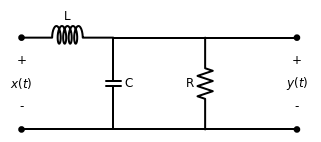

In [42]:
import schemdraw
import schemdraw.elements as elm

import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

d = schemdraw.Drawing(fontsize=12)
d += (A1 := elm.Dot())
d += (L := elm.Inductor2().label('L'))
d += (C := elm.Capacitor().down().label('C', loc='bottom'))
d += (w1 := elm.Line().left().tox(A1.start))
d += (A2 := elm.Dot())
d += (w2 := elm.Line().right().at(C.start))
d += (R := elm.Resistor().down().label('R'))
d += (w4 := elm.Line().right().at(R.start))
d += (B1 := elm.Dot())
d += (w3 := elm.Line().right().at(C.end))
d += (w4 := elm.Line().right())
d += (B2 := elm.Dot())
d += (oc_out := elm.Gap().endpoints(B1.start, B2.end).label(['+', r'$y(t)$', '-']))
d += (oc_in := elm.Gap().endpoints(A1.start, A2.end).label(['+', r'$x(t)$', '-']))

d.draw()

No energy is stored in the capacitor and inductor for $t<0$. It is furthermore assumed that the input voltage $x(t) = 0$ for $t<0$. Hence $y(t) = 0$ and $\frac{d y(t)}{dt} = 0$ for $t<0$. Let $L = 0.05$, $R = 2$, $C = 0.040$ are used for the elements of the electrical network.

### Differential Equation

The differential equation describing the input/output relation of the electrical network is derived by applying [Kirchhoff's circuit laws](https://en.wikipedia.org/wiki/Kirchhoff's_circuit_laws) to the network. This results in the following ODE

\begin{equation}
C L \frac{d^2 y(t)}{dt^2} + \dfrac{L}{R} \frac{d y(t)}{dt} + y(t) = x(t)
\end{equation}

This ODE is defined in `SymPy`

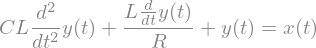

In [1]:
import sympy as sym
sym.init_printing()

t, L, R, C = sym.symbols('t L R C', real=True)
x = sym.Function('x')(t)
y = sym.Function('y')(t)

ode = sym.Eq(L*C*y.diff(t, 2) + (L/R)*y.diff(t) + y, x)
ode

The normalized values of the network elements are stored in a dictionary for later substitution

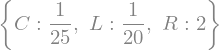

In [71]:
RLC = {R: 2, L: sym.Rational('.05'), C: sym.Rational('.040')}
RLC

### Impulse Response

The passive electrical network and the ODE describing its input/output relation can be interpreted as an LTI system. Hence, the system can be characterized by its impulse response $h(t)$ which is defined as the output of the system for a Dirac Delta impulse $x(t) = \delta(t)$ at the input. For the given system, the impulse response is calculated by explicit solution of the ODE

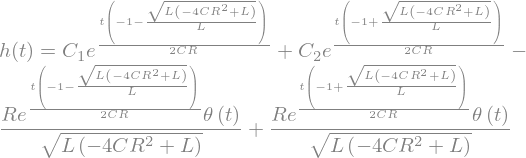

In [46]:
solution_h = sym.dsolve(
    ode.subs(x, sym.DiracDelta(t)).subs(y, sym.Function('h')(t)))
solution_h

The integration constants $C_1$ and $C_2$ have to be determined from the initial conditions $y(t) = 0$ and $\frac{d y(t)}{dt} = 0$ for $t<0$. 

In [47]:
integration_constants = sym.solve((solution_h.rhs.limit(
    t, 0, '-'), solution_h.rhs.diff(t).limit(t, 0, '-')), ['C1', 'C2'])
integration_constants

Substitution of the values for the integration constants $C_1$ and $C_2$ into the result from above yields the impulse response of the low-pass

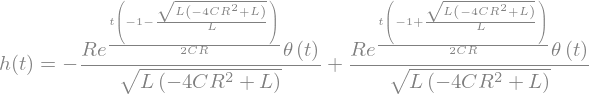

In [65]:
h = solution_h.subs(integration_constants)
h

The impulse response is plotted for the values of $R$, $L$ and $C$ given above

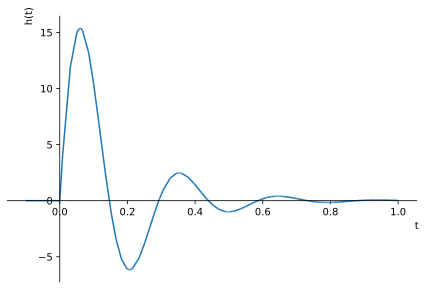

In [73]:
sym.plot(h.rhs.subs(RLC), (t, -.1, 1), ylabel=r'h(t)');

### Step Response

The step response is derived by integrating over the impulse response $h(t)$. It is the reponse of the system when a unit source is connected to the input terminal at time $t=0$. For ease of illustration this is performed for the specific values of the elements given above

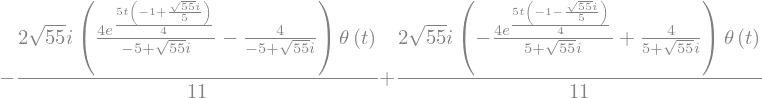

In [50]:
tau = sym.symbols('tau', real=True)

he = sym.integrate(h.rhs.subs(RLC).subs(t, tau), (tau, 0, t))
he

Let's plot the step response

In [2]:
sym.plot(he, (t, -.1, 5), ylabel=r'$h_\epsilon(t)$');

NameError: name 'he' is not defined

### Transfer Function

For an exponential input signal $x(t) = e^{s t}$, the transfer function $H(s)$ represents the complex weight of the exponential output signal $y(t) = H(s) \cdot e^{s t}$. The transfer function is derived by introducing $x(t)$ and $y(t)$ into the ODE and solving for $H(s)$

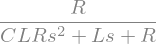

In [52]:
s = sym.symbols('s')
H = sym.Function('H')(s)

H, = sym.solve(ode.subs(x, sym.exp(s*t)).subs(y, H*sym.exp(s*t)).doit(), H)
H

The transfer characteristic of an LTI system for harmonic exponential signals $e^{j \omega t} = \cos(\omega t) + j \sin(\omega t)$ is of special interest for the analysis of electrical circuits. It can be derived from $H(s)$ by substituting the complex frequency $s$ by $s = j \omega$. The resulting transfer function $H(j \omega)$ provides the attenuation/amplification and phase the system adds to an harmonic input signal.

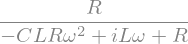

In [53]:
w = sym.symbols('omega', real=True)

Hjw = H.subs(s, sym.I * w)
Hjw

The magnitude of the transfer function $|H(j \omega)|$ and its phase are plotted for illustration for values of the elements given above.

We use the `control` package to plot the log-log graph of the mantide and the phase of $H(j\omega)$.

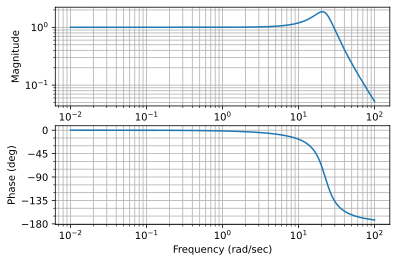

In [70]:
import control
import numpy

RLC = {R: 2, L: sym.Rational('.05'), C: sym.Rational('.04')}

G = control.tf(1, [float((C*L).subs(RLC).evalf()), float((L/R).subs(RLC).evalf()), 1])
omega = numpy.logspace(-2, 2, 1000)

control.bode(G, omega);

